In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%tensorflow_version 1.x
import pandas as pd
import tensorflow as tf
import nltk 
nltk.download('punkt')
import spacy

Mounted at /content/drive
TensorFlow 1.x selected.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Import Dataset**

Run through the normal data preprocessing, remove stop words, replace special characters, remove stopwords

In [3]:
input = pd.read_csv('/content/drive/MyDrive/nlp-getting-started/train.csv')

In [4]:
pd.set_option('display.max_colwidth', None)
input[['text']].iloc[0:20]

,text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas"
7,I'm on top of the hill and I can see a fire in the woods...
8,There's an emergency evacuation happening now in the building across the street
9,I'm afraid that the tornado is coming to our area...


In [5]:
#Replacing apostrophe words
input['text'] = input['text'].str.replace(r"(ain't )","are not ")
input['text'] = input['text'].str.replace(r"(can't )","can not ")
input['text'] = input['text'].str.replace(r"(shan't )|(sha'n't )", "shall not ")
input['text'] = input['text'].str.replace(r"(n't )"," not ")
input['text'] = input['text'].str.replace(r"('ve )"," have ")
input['text'] = input['text'].str.replace(r"('cause )", "because ")
input['text'] = input['text'].str.replace(r"('d )", " would ")
input['text'] = input['text'].str.replace(r"('ll )", " will ")
input['text'] = input['text'].str.replace(r"(let's )", "let us ")
input['text'] = input['text'].str.replace(r"('s )", " is ")
input['text'] = input['text'].str.replace(r"('y )", " you ")
input['text'] = input['text'].str.replace(r"('m )", " am ")
input['text'] = input['text'].str.replace(r"('re )", " are ")
input['text'] = input['text'].str.replace(r"(o'clock )", " of the clock ")
input['text'] = input['text'].str.replace(r"(ma'am )", "madam ")
input['text'] = input['text'].str.replace(r"(y'all )", "you all ")

In [6]:
#replacing links
input['text'] = input['text'].str.replace(r"https?([^\s]+)","")

In [7]:
#replacing twitter handles
input['text'] = input['text'].str.replace(r'@\w+','')

In [8]:
#Replacing punctuation
input['text'] = input['text'].str.replace(r'[^a-zA-Z0-9\s]', '')

In [9]:
#replacing numbers not working
input['text'] = input['text'].str.replace(r'[0-9]','')

In [10]:
#Everything lower
input['text'] = input['text'].str.lower()

In [11]:
input['text'].iloc[0:20]

0                                                                   our deeds are the reason of this earthquake may allah forgive us all
1                                                                                                  forest fire near la ronge sask canada
2     all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
3                                                                              people receive wildfires evacuation orders in california 
4                                                 just got sent this photo from ruby alaska as smoke from wildfires pours into a school 
5                                  rockyfire update  california hwy  closed in both directions due to lake county fire  cafire wildfires
6                                           flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas
7                                        

**BERT Start**

In [12]:
new_input = pd.DataFrame(columns = ['sentence','label'])
new_input['sentence'] = input['text']
new_input['label'] = input['target'].astype(int)
new_input

,sentence,label
0,our deeds are the reason of this earthquake may allah forgive us all,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1
3,people receive wildfires evacuation orders in california,1
4,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1
...,...,...
7608,two giant cranes holding a bridge collapse into nearby homes,1
7609,the out of control wild fires in california even in the northern part of the state very troubling,1
7610,m utckm s of volcano hawaii,1
7611,police investigating after an ebike collided with a car in little portugal ebike rider suffered serious nonlife threatening injuries,1


In [13]:
!pip install transformers

     |████████████████████████████████| 2.1MB 11.9MB/s 
     |████████████████████████████████| 901kB 57.3MB/s 
     |████████████████████████████████| 3.3MB 55.5MB/s 


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [15]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [16]:
tokenized = new_input['sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [20]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [21]:
np.array(padded).shape

(7613, 42)

In [22]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(7613, 42)

In [23]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [24]:
features = last_hidden_states[0][:,0,:].numpy()

In [25]:
labels = new_input['label']

In [41]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [27]:
train_features.shape,train_labels.shape

((5709, 768), (5709,))

In [28]:
X_train = train_features.reshape(train_features.shape[0],train_features.shape[1],1)
X_test = test_features.reshape(test_features.shape[0],test_features.shape[1],1)
Y_train = train_labels.values.reshape(-1,1)
Y_test = test_labels.values.reshape(-1,1)

In [29]:
X_train.shape, X_test.shape,Y_train.shape,Y_test.shape

((5709, 768, 1), (1904, 768, 1), (5709, 1), (1904, 1))

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model,Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,SpatialDropout1D,Flatten,Conv1D,MaxPooling1D,UpSampling1D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


In [120]:
model = Sequential()
model.add(Dropout(0.3))
model.add(Dense(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [101]:
model.summary()

ValueError: ignored

In [33]:
model = Sequential()
model.add(LSTM(100, input_shape = (X_train.shape[1],1)))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [114]:
model = Sequential()
model.add(Dropout(0.3))
model.add(LSTM(128,return_sequences=True, input_shape = (X_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate = 0.001)

In [78]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate = 0.00001)

In [ ]:
model = Sequential()

model.add(Conv1D(64,3,activation='relu',padding='same'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(128,3,activation='relu',padding='same'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(2))

model.add(Conv1D(128,3,activation='relu',padding='same'))
model.add(Dropout(0.5))
model.add(UpSampling1D(2))

model.add(Conv1D(64,3,activation='relu',padding='same'))
model.add(Dropout(0.5))
model.add(UpSampling1D(2))

model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics = ['accuracy'])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [38]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=2)

In [121]:
history = model.fit(train_features, train_labels.values,batch_size=128, epochs=100,validation_data=(test_features,test_labels.values))

Train on 5709 samples, validate on 1904 samples
Epoch 1/100
5709/5709 [==============================] - 1s 142us/step - loss: 0.9309 - accuracy: 0.4260 - val_loss: 0.8049 - val_accuracy: 0.4060
Epoch 2/100
5709/5709 [==============================] - 0s 57us/step - loss: 0.8114 - accuracy: 0.4631 - val_loss: 0.7293 - val_accuracy: 0.4191
Epoch 3/100
5709/5709 [==============================] - 0s 57us/step - loss: 0.7659 - accuracy: 0.4922 - val_loss: 0.6912 - val_accuracy: 0.5158
Epoch 4/100
5709/5709 [==============================] - 0s 59us/step - loss: 0.7348 - accuracy: 0.5234 - val_loss: 0.6645 - val_accuracy: 0.6077
Epoch 5/100
5709/5709 [==============================] - 0s 64us/step - loss: 0.7019 - accuracy: 0.5588 - val_loss: 0.6423 - val_accuracy: 0.6702
Epoch 6/100
5709/5709 [==============================] - 0s 69us/step - loss: 0.6815 - accuracy: 0.5829 - val_loss: 0.6227 - val_accuracy: 0.7080
Epoch 7/100
5709/5709 [==============================] - 0s 65us/step - los

In [124]:
predict = model.predict(test_features)
predict = predict > 0.5
print(classification_report(predict.astype(int),test_labels.astype(int)))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1219
           1       0.70      0.80      0.75       685

    accuracy                           0.80      1904
   macro avg       0.79      0.80      0.79      1904
weighted avg       0.81      0.80      0.81      1904



In [ ]:
history = model.fit(X_train, Y_train,batch_size=128, epochs=50,validation_data=(X_test,Y_test))

In [68]:
# Defining a function for plotting training and validation learning curves
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
  

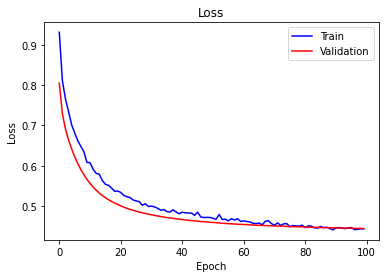

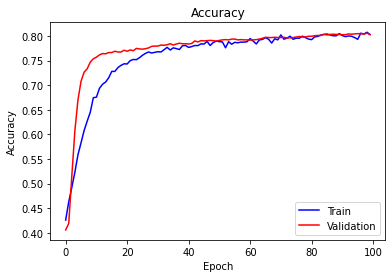

In [122]:
plot_history(history)

In [47]:
from sklearn.metrics import classification_report

In [ ]:
yprediction = model.predict(X_test)

In [ ]:
yprediction = yprediction > 0.5


In [ ]:
yprediction

array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [False],
       [False]])

In [46]:
print(classification_report(yprediction.astype(int),Y_test.astype(int)))

NameError: ignored

In [42]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [43]:
lr_prediction = lr_clf.predict(test_features)

In [44]:
lr_prediction

array([1, 0, 1, ..., 1, 0, 0])

In [48]:
print(classification_report(lr_prediction.astype(int),test_labels.astype(int)))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1191
           1       0.72      0.80      0.76       713

    accuracy                           0.81      1904
   macro avg       0.80      0.81      0.80      1904
weighted avg       0.82      0.81      0.81      1904



**Predict Individual Tweets**

Too possibly use during symposium

In [ ]:
def create_prediction_df(tweet,label,current_model):
  prediction_input = pd.DataFrame(columns = ['sentence','label'])
  prediction_input = prediction_input.append({'sentence': tweet, 'label': label},ignore_index=True)  
  #Replacing apostrophe words
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"(ain't )","are not ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"(can't )","can not ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"(shan't )|(sha'n't )", "shall not ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"(n't )"," not ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"('ve )"," have ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"('cause )", "because ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"('d )", " would ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"('ll )", " will ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"(let's )", "let us ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"('s )", " is ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"('y )", " you ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"('m )", " am ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"('re )", " are ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"(o'clock )", " of the clock ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"(ma'am )", "madam ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"(y'all )", "you all ")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r"https?([^\s]+)","")
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r'@\w+','')
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r'[^a-zA-Z0-9\s]', '')
  prediction_input['sentence'] = prediction_input['sentence'].str.replace(r'[0-9]','')
  prediction_input['sentence'] = prediction_input['sentence'].str.lower() 
  prediction_input['label'] = prediction_input['label'].astype(int)

  # For DistilBERT:
  model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

  ## Want BERT instead of distilBERT? Uncomment the following line:
  #model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

  # Load pretrained model/tokenizer
  tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
  bertmodel = model_class.from_pretrained(pretrained_weights)

  tokenized = prediction_input['sentence'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)

  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

  attention_mask = np.where(padded != 0, 1, 0)

  input_ids = torch.tensor(padded)  
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
    last_hidden_states = bertmodel(input_ids, attention_mask=attention_mask)
  
  features = last_hidden_states[0][:,0,:].numpy()

  labels = prediction_input['label']
  
  feature_reshape = features.reshape((features.shape[0],features.shape[1],1))

  modelprediction = current_model.predict(feature_reshape)

  modelprediction = modelprediction > 0.5

  return modelprediction

In [ ]:
tweet = "oh my god my house was just sold"
output_label = 0
prediction_feature,prediction_label = create_prediction_df(tweet,output_label)
prediction_tweet = prediction_feature.reshape(prediction_feature.shape[0],prediction_feature.shape[1],1)

In [ ]:
prediction = model.predict(prediction_tweet)
prediction = prediction > 0.5
print("Prediction for Disaster: {}".format(prediction))
print("Actual Label for Disaster: {}".format(prediction_label[0].astype(bool)))

Prediction for Disaster: [[False]]
Actual Label for Disaster: True


In [ ]:
tweet = "There is going to be a hurricane at the beach"
output_label = True
print("Tweet : {}".format(tweet))
print("Model Prediction, Is it a disaster? : {}".format(create_prediction_df(tweet,output_label,model)))
print("Actual label is : {}".format(output_label))

Tweet : There is going to be a hurricane at the beach
Model Prediction, Is it a disaster? : [[ True]]
Actual label is : True
